In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import utils.tavr_torch as tavr_torch
from utils.tavr_torch import TAVR_3_Frame, TAVR_1_Frame, TAVR_Sequence, tavr_dataloader
from utils.visualization import display_grid, z_stretch, visualize_frame, set_figsize, get_central_slices
from utils.loss_functions import batch_l2_loss
from utils.run_model import train, test
from Models.basic_models import average_model, two_layer_basic


set_figsize(20, 15)

Training directory found, 36 series
Validation directory found, 6 series
Testing directory found, 10 series


In [2]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

validation = TAVR_3_Frame("__valid")
val_loader = tavr_dataloader(validation, batch_size=4, shuffle=True, num_workers=2)
training = TAVR_3_Frame("__train")
train_loader = tavr_dataloader(training, batch_size=8, shuffle=True, num_workers=2)

ave_model = average_model()
model = two_layer_basic()
loss_fn = batch_l2_loss()

using device: cpu


In [3]:
learning_rate = 1e-5
momentum = 0.90
reg = 1e-7

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg, nesterov=True)

In [4]:
train(model, optimizer, train_loader, val_loader, loss_fn, device, 
         epochs=3, print_every=30, print_level=3, lr_decay=0.8)


****Epoch 0 Iteration 0, loss = 1948.9189
Validation loss 420.3997 over 81 frames
conv_a1.weight,   	norm: 3.8977e+00, 	update norm: 6.3174e-02 	Update/norm: 1.6208e-02
conv_a1.bias,   	norm: 2.8309e-01, 	update norm: 1.1521e-05 	Update/norm: 4.0697e-05
conv_b1.weight,   	norm: 4.0839e+00, 	update norm: 1.3221e-01 	Update/norm: 3.2373e-02
conv_b1.bias,   	norm: 3.3950e-01, 	update norm: 2.3922e-05 	Update/norm: 7.0462e-05
final.weight,   	norm: 1.7279e+00, 	update norm: 9.5138e-02 	Update/norm: 5.5060e-02
final.bias,   	norm: 1.8353e-01, 	update norm: 1.6347e-05 	Update/norm: 8.9066e-05

Iter 0... ... ... 
Iter 10... ... ... 
Iter 20... ... ... 
Iteration 30, loss = 117.7154
Validation loss 112.0503 over 81 frames
conv_a1.weight,   	norm: 3.8821e+00, 	update norm: 2.5271e-02 	Update/norm: 6.5096e-03
conv_a1.bias,   	norm: 2.8309e-01, 	update norm: 4.8779e-06 	Update/norm: 1.7231e-05
conv_b1.weight,   	norm: 4.0820e+00, 	update norm: 1.4718e-02 	Update/norm: 3.6054e-03
conv_b1.bias,   

In [ ]:
# Reset the learning rate, stop lr decay, train 3 more epochs
optimizer.param_groups[0]['lr'] = 1e-5
train(model, optimizer, train_loader, val_loader, loss_fn, device, 
         epochs=3, print_every=30, print_level=3)

Validation loss 47.5995 over 81 frames
Validation loss 36.8395 over 81 frames


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


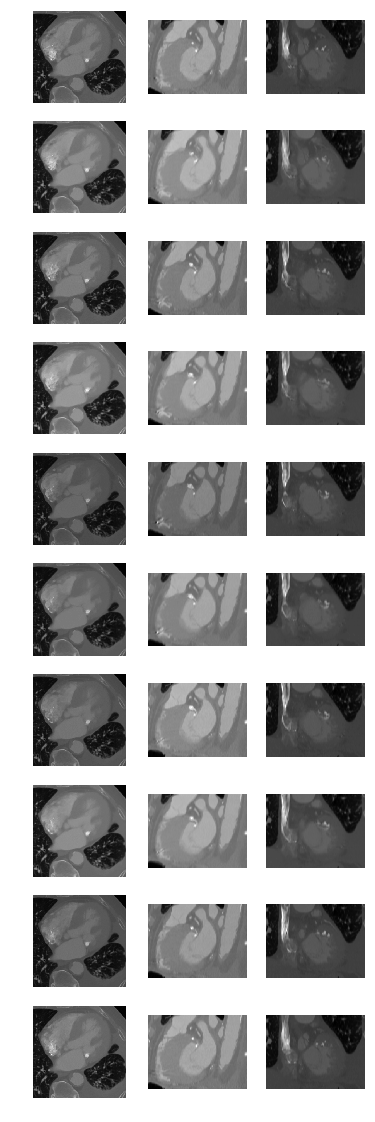

In [5]:
# One last test + visualize results on 1 validation sequence
val_seq = TAVR_Sequence("__valid")
test(model, val_loader, loss_fn, device)
test(ave_model, val_loader, loss_fn, device)

with torch.no_grad():
    model.eval()
    ave_frames = [val_seq[0][0]]
    for i in range(2,9,2):
        ave_frame = model((val_seq[0][i-2][None,:], val_seq[0][i][None,:]))
        ave_frames += [ave_frame[0][0],  val_seq[0][i]]
    ave_frames += [val_seq[0][9]]
    ave_frames_slices = []
    for f in ave_frames:
        ave_frames_slices += get_central_slices(f)
    set_figsize(6,20)
    display_grid(10, 3, ave_frames_slices)